In [1]:
import torch
from torch import nn
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from dgl import data, to_networkx
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch


# Distributed GCN Training
---
## Data preparation

The $\texttt{CORA}$ dataset consists in a graph $\mathcal G(V,E)$ of scientific publications. There is an edge between node $i$ and $j$ if there is a citation between the two documents. Each documeny is described by a label $y\in\{0,\dots,6\}$ and a feature vector $\textbf x\in \{0,1\}^{|D|}$, where $x_k$ denotes the presence of word $k$ in the document ($D$ is the dictionary). 

The main task is node classification, that means infer the category of some documents given the structure of the graph.

<p align="center">
    <img src="Images/CoraBalloons.png" width="700">
</p>

(Image from https://graphsandnetworks.com/the-cora-dataset/)

In [2]:
dataset = data.citation_graph.CoraGraphDataset()

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [3]:
G = dataset[0]
X = G.ndata['feat']
y = G.ndata['label']
A = G.adj().to_dense()

In [4]:
train_idx = G.ndata['train_mask'].bool()
val_idx =  G.ndata['val_mask'].bool()
test_idx =  G.ndata['test_mask'].bool()

## Graph Neural Networks
GNN are a type of Neural Networks designed specifically to deal with a graph domain. Simlarly to CNNs, they are made of layers that can exploit local information, but, differently from images, in this case the connectivity structure is irregular. 

The basic graph convolutional layer is defined as 

$$[\textbf H]_i=\phi\left(\sum_{j\in{\cal  N_i}} A_{ij} \textbf{W}^T \textbf{x}_j\right) \quad i=1,\dots,|V|$$

or, in a compact form

$$ \textbf H = \phi(\bf AXW)$$


<p align="center">
    <img src="Images/gcn.png" width="450">
</p>

(Image from https://spindro.github.io/post/gnn/)

However the use of the adjacency matrix $\textbf A$ is suboptimal since it can lead to numerical instabilities. The common choice is the _renormalization trick_ by Kipf and Welling. We define $\tilde{ \textbf A} = \textbf A + \textbf I$ and its degree matrix $\tilde{\textbf D}$. Then we compute the (re)-normalized Laplacian $$\textbf{K}:=\textbf I + \tilde{\textbf D}^{-\frac 12}\tilde{ \textbf A}\tilde{\textbf D}^{-\frac 12}$$ In this way the eigenvalues are bounded in $[0,1]$



## Agent Graph

In distributed optimization over networks we have $N$ computing agents having a sparse connectivity structure represented by a communication graph $\mathcal{G}_{com}$. We assume that our data is distributed across the agents and we want to optimize a _global_ objective function. The only assumtion required about $\mathcal{G}_{com}$ is that it is connected, so that the information can be propagated between each pair of nodes.

In [5]:
def build_agent_graph(N, p):
    G_agents = nx.erdos_renyi_graph(N, p)
    while not nx.is_connected(G_agents):
        G_agents = nx.erdos_renyi_graph(N, p)

    nx.draw_spring(G_agents)
    plt.title("Communication Graph")
    plt.show()

    return nx.adjacency_matrix(G_agents).todense() + np.eye(N_agents), G_agents

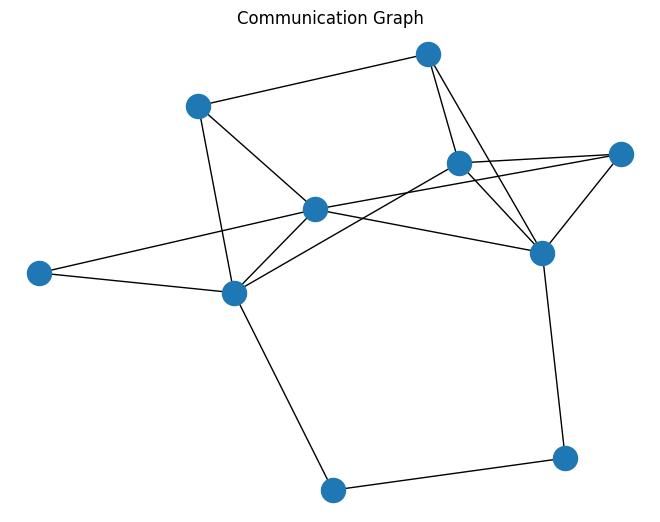

In [6]:
N_agents = 10
communication_matrix, G_agents = build_agent_graph(N_agents, 0.3)

In this distributed setup each agent must have its own weight matrix, hence the GCN layers can be read as 

$$[\textbf H]_i=\phi\left(\sum_{j\in{\cal  N_i}} A_{ij} \textbf{W}_{a(j)}^T \textbf{x}_j\right) \quad i=1,\dots,|V|$$

where $a(j)$ is a function that match node $j$ with its related agent. In order to compute this layer, agent $a(i)$ must receive the aggregation-phase information from the other agents 

$$ \sum_{j\in \mathcal N_i}\mathbb I\{\text{Node j assigned to agent z} \} A_{ij} \textbf{W}_{z}^T \textbf{x}_j$$

In this case the nodes are assigned to the agents randomly, since standard clusering procedures lead to heavily unbalanced cluster (one big component and isolated nodes). 


In [7]:
def prune_connections(A, communication_matrix, node_assignment):
    # Modify the adjacency matrix in such way that the message 
    # passing is allowed only between communicating agents
    new_A = A.copy()
    N_agents = communication_matrix.shape[0]
    if not communication_matrix.all():
        for i in range(N_agents):
            I = (node_assignment==i).astype('int32')
            for j in range(i+1,N_agents):
                J = (node_assignment==j).astype('int32')
                if communication_matrix[i,j]==0:
                    # If there is no communication path between agent I and J
                    # remove the connetions (if there are any) from the nodes
                    # assigned to I and the nodes assigned to J
                    IJ = np.outer(I,J) # All possible connections from I to J
                    new_A -= (A*IJ) # Removing
    return new_A

In [8]:
def get_diffusion_matrix(A, communication_matrix, node_assignment):
    new_A = prune_connections(A.numpy(), communication_matrix, node_assignment)
    new_A = new_A + np.eye(new_A.shape[0])
    I = np.identity(A.shape[0])
    d = new_A.sum(axis=0)
    D_inv_sqrt = I/np.sqrt(d)
    W = I + D_inv_sqrt@new_A@D_inv_sqrt
    return torch.from_numpy(W).float()

In [9]:
node_assignment = np.random.randint(0, N_agents, X.shape[0])

# Compute renormalized diffusion matrix 
diffusion_matrix = get_diffusion_matrix(A, communication_matrix, node_assignment)

## Training

Since we have different weights for each agent we need to enforce consensus on them. Moreover, this consensus must be imposed locally, since by assumption we do not have a central processor. This is done by using a matrix $\textbf C$ that acts as projection operator onto the consensus space.  

The distributed training procedure goes as follows

<p align="center">
    <img src="Images/alg.png" width="450">
</p>

Where [15] is the local gradient for each agent. The matrix $\textbf C$ must satisfy some assumptions and it can be computed in various way. In this case we do it by optmization via ADMM 

<p align="center">
    <img src="Images/consensus.png" width="450">
</p>

You may refer to the paper for the derivation of the algorithm.

In [10]:
def projection_matrix(X, Pi):
    # (35)
    B = np.eye(Pi.shape[0]) - Pi
    return B@((X+X.T)/2)@B

def get_beta(lam, gamma):
    # (34)
    mask1 = (lam < -1 + gamma)
    mask2 = (lam > 1 - gamma)
    mask3 = (np.abs(lam) <= 1 - gamma)
    beta = np.zeros(lam.shape[0])
    beta[mask1] = -1 + gamma
    beta[mask2] = 1 - gamma
    beta[mask3] = lam[mask3]
    return beta

def projection_step(X, Pi, gamma):
    # (33)
    lam, V = np.linalg.eig(projection_matrix(X, Pi))
    m = lam.shape[0]
    beta = get_beta(lam, gamma)
    return Pi + V@np.diag(beta)@V.T

def soft_tresholding_step(C, U, A, rho):
    # (32)
    X = np.multiply((C+U), A)
    mask1 = (X > rho)
    mask2 = (X > - rho)|(X < rho)
    mask3 = (X < - rho)
    np.putmask(X, mask1, X-rho)
    np.putmask(X, mask2, 0)
    np.putmask(X, mask3, X+rho)
    return X + np.multiply((C + U),(1-A))

def compute_consensus_matrix(communication_matrix):
    # Compute matrix that respects A1, A2, A3
    
    N_agents = communication_matrix.shape[0]
    C = np.random.randn(N_agents,N_agents)
    Z = np.random.randn(N_agents,N_agents)
    U = np.random.randn(N_agents,N_agents)
    Pi = (1/N_agents)*np.ones((N_agents,N_agents))
    gamma = 0.6
    rho = 2
    
    for i in range(100):
        C = projection_step(Z-U, Pi, gamma)
        Z = soft_tresholding_step(C, U, communication_matrix, rho)
        U = U + C - Z
    
    return torch.from_numpy(C).float()

In [11]:
agent_matrix = compute_consensus_matrix(communication_matrix)

In [12]:
class MyGCN(nn.Module):
    def __init__(self, X, N_agents, hidden_size, 
                 output_size, dropout_p=0.5):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layer1 = nn.ModuleList()
        self.layer2 = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_p)
        self.N_agents = N_agents
        
        # Initialize weights for each agent
        for i in range(N_agents):
            self.layer1.append(nn.Linear(X.shape[1], hidden_size))
            self.layer2.append(nn.Linear(hidden_size, output_size))
            
    def forward(self, diffusion_matrix, X, node_assignment):
        H = torch.zeros(X.shape[0], self.hidden_size)
        
        # Local aggregation step
        for i in range(N_agents):
            H[node_assignment==i] = self.layer1[i](X[node_assignment==i])
        
        # Message passing 
        H = torch.matmul(diffusion_matrix, H)
        H = torch.nn.ReLU()(H)
        H = self.dropout(H)
        
        # Second local aggregation step 
        Y = torch.zeros(X.shape[0], self.output_size)
        for i in range(N_agents):
            Y[node_assignment==i] = self.layer2[i](H[node_assignment==i])
            
        # Message passing and softmax
        return nn.Softmax(dim=1)(torch.matmul(diffusion_matrix, Y))

In [13]:
def merge_iterators(a, b):
    # This is used for managing the parameters 
    for i, j in zip(a,b):
        yield i
        yield j

In [14]:
 def accuracy(y, y_pred):
    return (torch.sum(torch.argmax(y_pred, dim=1) == y))/y.shape[0]

In [15]:
def consensus_step(model, C):
    # Vectorize parameters in the correct order
    flatten = [parameters_to_vector(merge_iterators(
        model.layer1[i].parameters(),
        model.layer2[i].parameters())) for i in range(C.shape[0])]
    
    p_flat = torch.stack(flatten)
    # Enforce consensus 
    p_flat = torch.matmul(C, p_flat)
    
    # Put the parameters back where they belong
    for i, row in enumerate(p_flat):
        vector_to_parameters(
            p_flat[i], 
            merge_iterators(model.layer1[i].parameters(),
                            model.layer2[i].parameters())
        )

In [16]:
def train(model, agent_matrix, consensus=True, N_iter=100, plot_title=""):
    # Set up optimizers
    agents_opts = []
    for i in range(0,N_agents):
        agents_opts.append(torch.optim.Adam(merge_iterators(
            model.layer1[i].parameters(),
            model.layer2[i].parameters()), lr=learning_rate))

    results =  {'tr_loss':[],'tr_acc':[],'te_acc':[]}
    
    # Train
    for epoch in range(N_iter):
        model.train()
        # Prediction
        y_pred = model(diffusion_matrix, X, node_assignment)
        loss = loss_fn(y_pred[train_idx], y[train_idx])
        loss.backward()
        
        # Consensus
        if consensus:
            if epoch > 1:
                with torch.no_grad():
                    consensus_step(model, agent_matrix)
                    
        # Local gradient estimate
        for j in range(N_agents):
            agents_opts[j].step()
            agents_opts[j].zero_grad()
        
        # Evaluate metrics
        model.eval()
        y_pred = model(diffusion_matrix, X, node_assignment)
        
        results['tr_loss'].append(loss.item())
        results['tr_acc'].append(accuracy(y[train_idx], y_pred[train_idx]))
        results['te_acc'].append(accuracy(y[test_idx], y_pred[test_idx]))

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
    ax1.plot(results['tr_loss'], label='Training loss')
    ax1.legend()
    ax2.plot(results['tr_acc'], label='Training accuracy')
    ax2.plot(results['te_acc'], label='Test accuracy')
    ax2.legend()
    fig.suptitle(plot_title)
    plt.show()

In [17]:
learning_rate = 0.01
dropout_prob = 0.4
hidden_size = 64
output_size = int(torch.max(y) + 1)
gcn = MyGCN(X, N_agents, hidden_size, output_size, dropout_prob)
loss_fn = nn.CrossEntropyLoss()

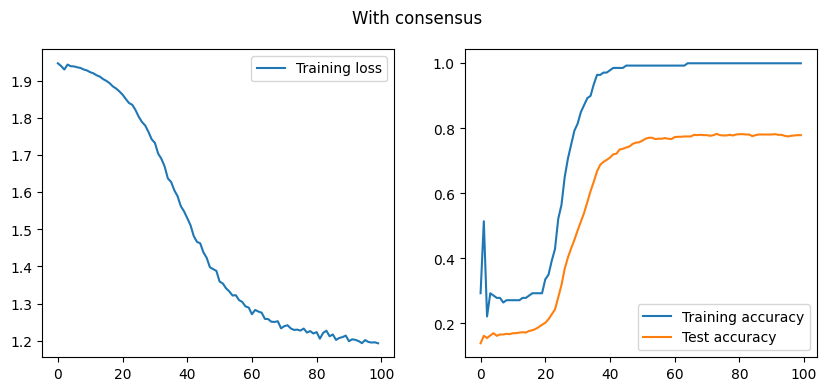

In [18]:
train(gcn, agent_matrix, N_iter=100, plot_title="With consensus")

In [19]:
gcn = MyGCN(X, N_agents, hidden_size, output_size, dropout_prob)
loss_fn = nn.CrossEntropyLoss()

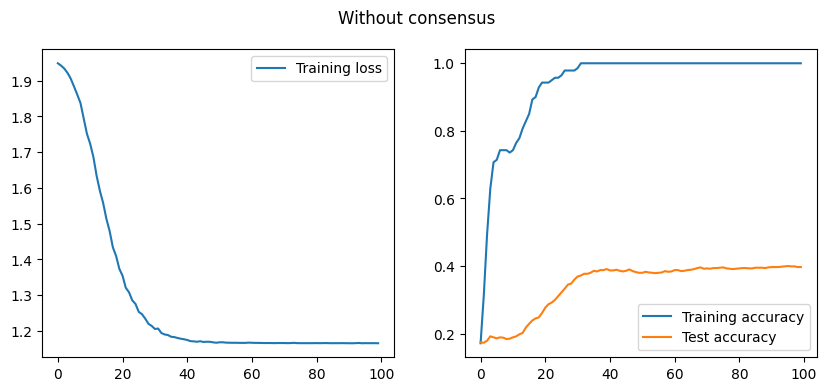

In [20]:
train(gcn, agent_matrix, consensus=False, N_iter=100, plot_title="Without consensus")